![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/quickstart-ci/ClassificationWithAutomatedML.png)

In [11]:
%run ../../../forth.py

p e f o r t h    v1.28
source code http://github.com/hcchengithub/peforth
Type 'peforth.ok()' to enter forth interpreter, 'exit' to come back.

*** Start self-test 
*** Data stack should be empty ... pass
*** Rreturn stack should have less than 2 cells ... pass
*** // adds help to the last word ... pass
*** TIB lines after \ should be ignored ... pass
*** slice ... pass
reDef ---
*** case ... endcase ... pass
*** modules lists imported modules ... pass
*** cd mimic DOS/Linux cd command ... pass
*** debugger commands x@ x> >x .sx xdrop xdropall ... pass
*** xstack commands x@ x> >x .sx xdrop xdropall ... pass
*** /// add comment to the last word ... pass
*** immediate makes the LAST an immediate word ... pass
*** compyle source code to function ... pass
*** </pyV> based on </py> and on compyle ... pass
*** interpret-only marks the last word an interpret-only word ... pass
*** immediate marks the last word an immediate word ... pass
*** compile-only marks last word as a compile-only word

# Quickstart: Fraud Classification using Automated ML

In this quickstart, you use automated machine learning in Azure Machine Learning service to  train a classification model on an associated fraud credit card dataset. This process accepts training data and configuration settings, and automatically iterates through combinations of different feature normalization/standardization methods, models, and hyperparameter settings to arrive at the best model.

You will learn how to:

> * Download a dataset and look at the data
> * Train a machine learning classification model using autoML 
> * Explore the results


### Connect to your workspace and create an experiment

You start with importing some libraries and creating an experiment to track the runs in your workspace. A workspace can have multiple experiments, and all the users that have access to the workspace can collaborate on them. 

In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [2]:
ws = Workspace.from_config(r"../../../.azureml/config.json") # root configuration.ipynb 建立的

In [3]:
# choose a name for your experiment
experiment_name = "fraud-classification-automl-tutorial"

experiment = Experiment(ws, experiment_name)

上 Azure AML studio web page 去看，真的有這個 experiment 出現了！

### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.


Follow this [how-to](https://aka.ms/azureml/howto/createdatasets) if you want to learn more about Datasets and how to use them.




In [5]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
dataset = Dataset.Tabular.from_delimited_files(data)
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)
label_column_name = "Class"

In [16]:
%f training_data -->

training_data --> TabularDataset
{
  "source": [
    "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/creditcard.csv"
  ],
  "definition": [
    "GetFiles",
    "ParseDelimited",
    "DropColumns",
    "SetColumnTypes",
    "TakeSample"
  ]
} (<class 'azureml.data.tabular_dataset.TabularDataset'>)


## Train



When you use automated machine learning in Azure ML, you input training data and configuration settings, and the process automatically iterates through combinations of different feature normalization/standardization methods, models, and hyperparameter settings to arrive at the best model. 
Learn more about how you configure automated ML [here](https://docs.microsoft.com/azure/machine-learning/how-to-configure-auto-train).


Instantiate an [AutoMLConfig](https://docs.microsoft.com/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py) object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. 
|**enable_early_stopping**  | Stop the run if the metric score is not showing improvement.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|

You can find more information about primary metrics [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [17]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": "average_precision_score_weighted",
    "experiment_timeout_hours": 0.25,  # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ability to find the best model possible
    "verbosity": logging.INFO,
    "enable_stack_ensemble": False,
}

automl_config = AutoMLConfig(
    task="classification",
    debug_log="automl_errors.log",
    training_data=training_data,
    label_column_name=label_column_name,
    **automl_settings,
)

Call the `submit` method on the experiment object and pass the run configuration. 

**Note: Depending on the data and the number of iterations an AutoML run can take a while to complete.**

In this example, we specify `show_output = True` to print currently running iterations to the console. It is also possible to navigate to the experiment through the **Experiment** activity tab in the left menu, and monitor the run status from there.

In [18]:
local_run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
fraud-classification-automl-tutorial,AutoML_0cb9c1ec-a8f3-4980-aabb-b3ee87fd511e,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

********************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one cl

In [19]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
fraud-classification-automl-tutorial,AutoML_0cb9c1ec-a8f3-4980-aabb-b3ee87fd511e,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
%f local_run -->

local_run --> Run(Experiment: fraud-classification-automl-tutorial,
Id: AutoML_0cb9c1ec-a8f3-4980-aabb-b3ee87fd511e,
Type: automl,
Status: Completed) (<class 'azureml.train.automl.run.AutoMLRun'>)


### Analyze results

Below we select the best model from our iterations. The `get_output` method on `automl_classifier` returns the best run and the model for the run.

In [21]:
best_run, best_model = local_run.get_output()
best_model

PipelineWithYTransformations(Pipeline={'memory': None,
                                       'steps': [('datatransformer',
                                                  DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='C:\...
                                                  PreFittedSoftVotingClassifier(classification_labels=array([0, 1], dtype=int64), estimators=[('11', Pipeline(memory=None, steps=[('sparsenormalizer', Normalizer(copy=True, norm='l1')), ('lightgbmclassifier', LightGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8911111111111111, learning_rate=0.0842121052631579, max_bin=290, max_depth=3, min_child_weight=6, min_data_in_leaf=0.024145517241379314, min_split_gain=0.7368421052631579, n_estimators=25, n_jobs=1, num_leaves=137, problem_inf

## Tests

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [22]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(
    columns=[label_column_name]
).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(
    columns=[label_column_name], validate=True
).to_pandas_dataframe()

In [23]:
# call the predict functions on the model
y_pred = best_model.predict(X_test_df)
y_pred

array([False, False, False, ..., False, False, False])



### Calculate metrics for the prediction

Now visualize the data to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.



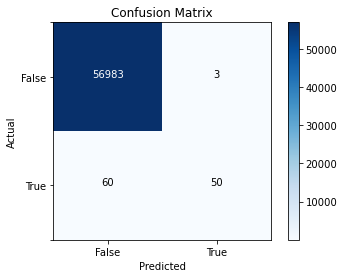

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf = confusion_matrix(y_test_df.values, y_pred)
plt.imshow(cf, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
class_labels = ["False", "True"]
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks([-0.5, 0, 1, 1.5], ["", "False", "True", ""])
# plotting text value inside cells
thresh = cf.max() / 2.0
for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
    plt.text(
        j,
        i,
        format(cf[i, j], "d"),
        horizontalalignment="center",
        color="white" if cf[i, j] > thresh else "black",
    )
plt.show()

## Control cost and further exploration

If you want to control cost you can stop the compute instance this notebook is running on by clicking the "Stop compute" button next to the status dropdown in the menu above.


If you want to run more notebook samples, you can click on **Sample Notebooks** next to the **Files** view and explore the notebooks made available for you there.